# PyTorch ResNet + UTKFace

Partially based [on this](https://www.kaggle.com/code/gxkok21/resnet50-with-pytorch/notebook)

In [8]:
import numpy as np 
import pandas as pd
import os
import copy
import glob
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision

# import skimage
from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
dataset_folder_name = '../data/UTKFace/Images'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 200

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [3]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [4]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,100.0,male,white,../data/UTKFace/Images/100_0_0_201701122135009...
1,100.0,male,white,../data/UTKFace/Images/100_0_0_201701122152403...
2,100.0,female,white,../data/UTKFace/Images/100_1_0_201701101837263...
3,100.0,female,white,../data/UTKFace/Images/100_1_0_201701122130019...
4,100.0,female,white,../data/UTKFace/Images/100_1_0_201701122133036...


Text(0, 0.5, '')

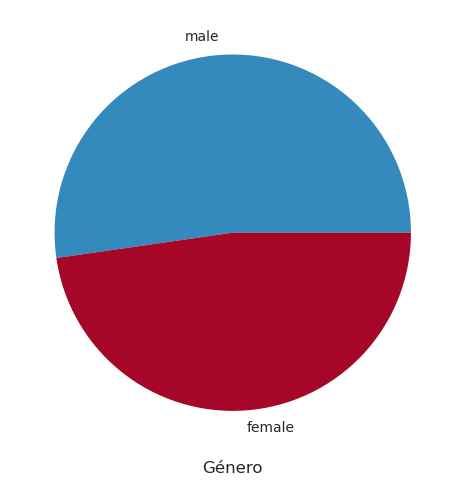

In [45]:
matplotlib.style.use('bmh')
ax = df["gender"].value_counts().plot(kind="pie")
ax.set_xlabel('Género')
ax.set_ylabel('')

Text(0, 0.5, '')

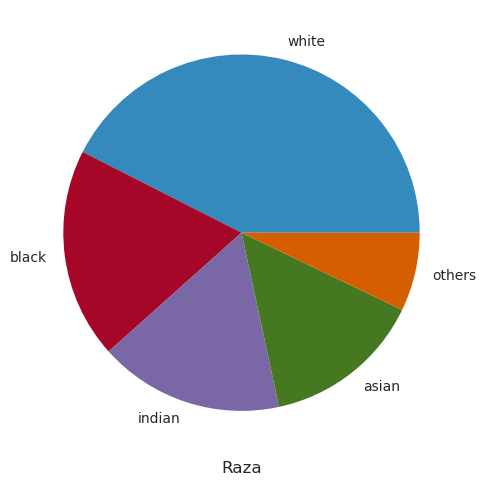

In [46]:
ax = df["race"].value_counts().plot(kind="pie")
ax.set_xlabel('Raza')
ax.set_ylabel('')

Text(0, 0.5, 'Nº de muestras')

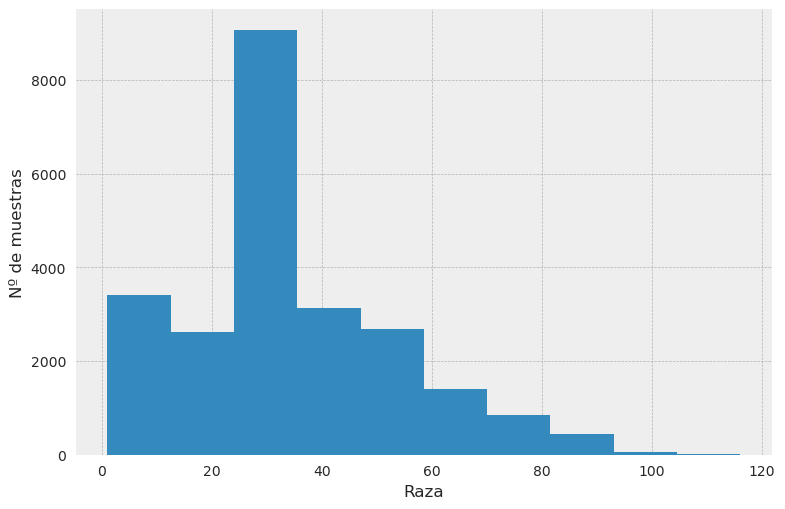

In [50]:
ax = df["age"].plot(kind="hist")
ax.set_xlabel('Edad')
ax.set_xlabel('Raza')
ax.set_ylabel('Nº de muestras')

In [17]:
train_indices, test_indices = train_test_split(df.index, test_size=0.25)

In [18]:
df.shape

(23705, 4)

In [19]:
class Dataset(torch.utils.data.Dataset):
    """
    This is our custom dataset class which will load the images, perform transforms on them,
    and load their corresponding labels.
    """
    
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.images = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".jpg")]
        self.transform = transform
        
    def __getitem__(self, idx):
        print(f'#{idx}...', end='')
        if idx >= self.df.shape[0]:
            idx = self.df.shape[0]-1
        img_path = self.df.iloc[idx]['file']
#         print("img_path:", img_path)
        print('OK')
        img = imread(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        sample = {
            "image": img,
        }
        sample["gender"] = dataset_dict['gender_alias'][self.df.iloc[idx]["gender"]]
        #sample["id"] = self.df.loc[idx, "id"]
        return sample
    
    def __len__(self):
        try:
            return self.df.shape[0]
        except AttributeError:
            return len(self.images)

In [20]:
transform_pipe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    # Resize image to 224 x 224 as required by most vision models
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    
    # Convert PIL image to tensor with image values in [0, 1]
    torchvision.transforms.ToTensor(),
    
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [21]:
train_data = Dataset(
    df=df,
    img_dir="../data/UTKFace/Images/",
    transform=transform_pipe
)

In [22]:
# The training dataset loader will randomly sample from the train samples
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64,
    sampler=torch.utils.data.SubsetRandomSampler(
        train_indices
    )
#     shuffle=True,
#     num_workers=8
)

In [23]:
# The testing dataset loader will randomly sample from the test samples
test_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64,
    sampler=torch.utils.data.SubsetRandomSampler(
        test_indices
    )
#     shuffle=True,
#     num_workers=8
)

In [24]:
dataloaders = {
    "train": train_loader,
    "test": test_loader
}

In [25]:
model = torchvision.models.resnet50() # WITH pre-trained weigths

In [26]:
# Replace final fully connected layer to suite problem
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=1
    ),
    torch.nn.Sigmoid()
)

In [27]:
out = model(train_data[0]["image"].view(1, 3, 224, 224))
out

#0...OK


tensor([[0.4381]], grad_fn=<SigmoidBackward>)

In [29]:
USE_GPU = True
EPOCHS = 5

In [30]:
# Model training
if USE_GPU:
    model = model.cuda() # Should be called before instantiating optimizer

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss() # For binary classification problem

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for i in range(EPOCHS):
    for phase in ["train", "test"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        samples = 0
        loss_sum = 0
        correct_sum = 0
        for j, batch in enumerate(dataloaders[phase]):
            X = batch["image"]
            genders = batch["gender"]
            if USE_GPU:
                X = X.cuda()
                genders = genders.cuda()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y = model(X)
                loss = criterion(
                    y, 
                    genders.view(-1, 1).float()
                )

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
                # We need to multiple by batch size as loss is the mean loss of the samples in the batch
                loss_sum += loss.item() * X.shape[0]
                samples += X.shape[0]
                num_corrects = torch.sum((y >= 0.5).float() == genders.view(-1, 1).float())
                correct_sum += num_corrects
                
                # Print batch statistics every 50 batches
                if j % 50 == 49 and phase == "train":
                    print("{}:{} - loss: {}, acc: {}".format(
                        i + 1, 
                        j + 1, 
                        float(loss_sum) / float(samples), 
                        float(correct_sum) / float(samples)
                    ))
                
        # Print epoch statistics
        epoch_acc = float(correct_sum) / float(samples)
        epoch_loss = float(loss_sum) / float(samples)
        print("epoch: {} - {} loss: {}, {} acc: {}".format(i + 1, phase, epoch_loss, phase, epoch_acc))
        
        # Deep copy the model
        if phase == "test" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "resnet50.pth")

#5721...OK
#6330...OK
#15529...OK
#21241...OK
#11117...OK
#1720...OK
#11966...OK
#22296...OK
#3370...OK
#20856...OK
#20905...OK
#10986...OK
#14583...OK
#749...OK
#16893...OK
#10964...OK
#7212...OK
#20890...OK
#13671...OK
#22047...OK
#18082...OK
#16905...OK
#14751...OK
#23570...OK
#1326...OK
#1464...OK
#10198...OK
#12500...OK
#7526...OK
#21755...OK
#314...OK
#16970...OK
#14064...OK
#5371...OK
#2225...OK
#10154...OK
#4964...OK
#5035...OK
#11843...OK
#12015...OK
#22816...OK
#1928...OK
#2812...OK
#15795...OK
#253...OK
#11955...OK
#11887...OK
#14464...OK
#16827...OK
#16522...OK
#14600...OK
#22098...OK
#12817...OK
#18484...OK
#9162...OK
#7171...OK
#20506...OK
#19897...OK
#464...OK
#14113...OK
#13710...OK
#17755...OK
#18183...OK
#19537...OK
#2218...OK
#6076...OK
#19997...OK
#13619...OK
#3177...OK
#931...OK
#16155...OK
#13651...OK
#14045...OK
#12745...OK
#23186...OK
#3557...OK
#10547...OK
#14517...OK
#22123...OK
#3489...OK
#22036...OK
#287...OK
#3530...OK
#5011...OK
#21363...OK
#265...OK
#1925

KeyboardInterrupt: 

In [31]:
# Reconstruct model from saved weights
model1 = torchvision.models.resnet50()
model1.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=1
    ),
    torch.nn.Sigmoid()
)
model1.load_state_dict(torch.load("resnet50.pth"))

<All keys matched successfully>

In [33]:
# Make predictions
model1.eval()
if USE_GPU:
    model1 = model1.cuda()

ids_all = []
predictions = []

for j, batch in enumerate(dataloaders['test']):
    X = batch["image"]
    ids = batch["id"]
    if USE_GPU:
        X = X.cuda()
    
    for _id in ids:
        ids_all.append(_id)

    with torch.set_grad_enabled(False):
        y_pred = model1(X)
        print(f'Prediction: {}')
        predictions.append((y_pred >= 0.5).float().cpu().numpy())
        
print("Done making predictions!")

#7329...OK
#3646...OK
#4940...OK
#2154...OK
#22607...OK
#12774...OK
#23040...OK
#22200...OK
#7373...OK
#6348...OK
#14281...OK
#8503...OK
#21283...OK
#15966...OK
#484...OK
#11960...OK
#20306...OK
#1921...OK
#13596...OK
#679...OK
#14474...OK
#22639...OK
#15447...OK
#13033...OK
#20757...OK
#2096...OK
#1673...OK
#1533...OK
#21102...OK
#19127...OK
#14344...OK
#3401...OK
#9379...OK
#18329...OK
#3527...OK
#17580...OK
#13051...OK
#19593...OK
#1542...OK
#20008...OK
#19996...OK
#12671...OK
#8445...OK
#21062...OK
#9973...OK
#22519...OK
#2401...OK
#19124...OK
#16261...OK
#13149...OK
#9376...OK
#3499...OK
#22001...OK
#19922...OK
#7575...OK
#4688...OK
#1880...OK
#11838...OK
#5980...OK
#13902...OK
#2384...OK
#11315...OK
#6201...OK
#15411...OK


KeyError: 'id'